<a href="https://colab.research.google.com/github/joshua-manoj/predictive-maintenance-pipeline/blob/main/maintenance_analysis_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⚠️ ALERT: Degradation detected at Cycle 122.0


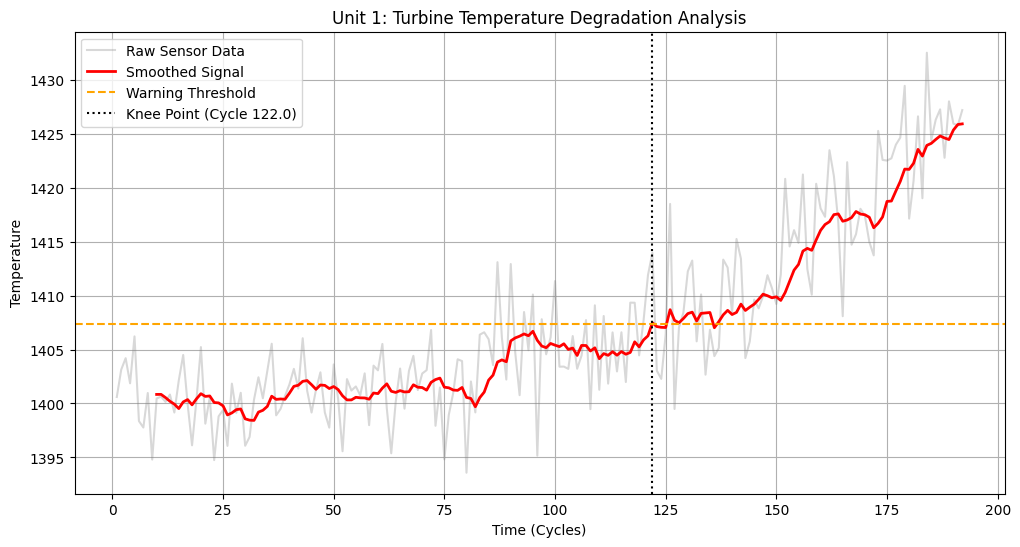

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('rul_data.csv')
unit_1 = df[df['unit_nr'] == 1].copy()


unit_1['s4_smoothed'] = unit_1['temp_turbine'].rolling(window=10).mean()


baseline = unit_1['s4_smoothed'].iloc[0:20].mean()
threshold = baseline * 1.005

knee_point_rows = unit_1[unit_1['s4_smoothed'] > threshold]

knee_cycle = None

if not knee_point_rows.empty:
    knee_cycle = knee_point_rows.iloc[0]['time_cycles']
    print(f"⚠️ ALERT: Degradation detected at Cycle {knee_cycle}")
else:
    print("✅ Unit is healthy (No degradation detected above threshold).")

plt.figure(figsize=(12, 6))

plt.plot(unit_1['time_cycles'], unit_1['temp_turbine'], label='Raw Sensor Data', alpha=0.3, color='gray')
plt.plot(unit_1['time_cycles'], unit_1['s4_smoothed'], label='Smoothed Signal', color='red', linewidth=2)
plt.axhline(y=threshold, color='orange', linestyle='--', label='Warning Threshold')

if knee_cycle is not None:
    plt.axvline(x=knee_cycle, color='black', linestyle=':', label=f'Knee Point (Cycle {knee_cycle})')
else:
    plt.text(10, baseline, "System Healthy", fontsize=12, color='green')

plt.title('Unit 1: Turbine Temperature Degradation Analysis')
plt.xlabel('Time (Cycles)')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd


df = pd.read_csv('train_FD001.csv')


max_cycles = df.groupby('unit_nr')['time_cycles'].transform('max')
df['RUL'] = max_cycles - df['time_cycles']

sensor_map = {
    's2': 'Thermal (Compressor)',    # Temperature
    's3': 'Thermal (Burner)',        # Temperature
    's4': 'Thermal (Turbine)',       # Temperature
    's7': 'Pressure (Hydraulics)',   # Pressure
    's11': 'Vibration (Static)',     # Vibration
    's12': 'Vibration (Kinetic)'     # Vibration
}


cols_to_keep = ['unit_nr', 'time_cycles', 'RUL'] + list(sensor_map.keys())

df_melted = df[cols_to_keep].melt(
    id_vars=['unit_nr', 'time_cycles', 'RUL'],
    value_vars=list(sensor_map.keys()),
    var_name='Sensor_ID',
    value_name='Sensor_Reading'
)
df_melted['Sensor_Type'] = df_melted['Sensor_ID'].map(sensor_map)
def assign_alert(rul):
    if rul <= 20: return "CRITICAL ALERT"
    elif rul <= 50: return "WARNING"
    else: return "NORMAL"

df_melted['Alert_Status'] = df_melted['RUL'].apply(assign_alert)
df_melted['Sensor_Mean'] = df_melted.groupby('Sensor_ID')['Sensor_Reading'].transform('mean')
df_melted['Sensor_Std'] = df_melted.groupby('Sensor_ID')['Sensor_Reading'].transform('std')
df_melted['Z_Score'] = (df_melted['Sensor_Reading'] - df_melted['Sensor_Mean']) / df_melted['Sensor_Std']
df_melted['Is_Anomaly'] = df_melted['Z_Score'].abs() > 2

df_melted.to_csv('final_dashboard_data.csv', index=False)
print("✅ Success! File 'final_dashboard_data.csv' created.")
print("   - This file has 'Sensor_Type' so you can filter Thermal vs Vibration in Tableau.")

✅ Success! File 'final_dashboard_data.csv' created.
   - This file has 'Sensor_Type' so you can filter Thermal vs Vibration in Tableau.
